In [87]:
# The dataset we'll use in this notebook originates from "kaggle".

!pip install -qU kagglehub

In [88]:
# Import the python packages that will be used throughout the notebook.

import os
import pandas as pd
import numpy as np
import seaborn as sns 
import joblib
import matplotlib.pyplot as plt 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools
from IPython.display import Markdown, display

In [141]:
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,log_loss

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
import itertools

pd.options.display.float_format = '{:.2f}'.format

import warnings                   # to deal with warnings
warnings.filterwarnings('ignore')

### 1. Download, read, explore and preprocess the data

#### 1.1 Download
Download the salary-prediction-classification dataset from "kaggle".

In [90]:
import kagglehub

# Download latest version
# ref. https://www.kaggle.com/datasets/ayessa/salary-prediction-classification/data
path = kagglehub.dataset_download("ayessa/salary-prediction-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/ayessa/salary-prediction-classification/versions/1


#### 1.2 Read the data

In [91]:
df = pd.read_csv(os.path.join(path, 'salary.csv'))

#### 1.3 Explore and preprocess the data

In [92]:
df.shape

(32561, 15)

In [198]:
for col in df.columns:
    print(col)

age
workclass
fnlwgt
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country
salary


In [199]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Check for duplicates

In [200]:
duplicates = df.duplicated().sum()
print(duplicates)

24


In [32]:
# Check for missing values
isna = df.isna().sum()
print(isna)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64


In [93]:
# Let's get rid of duplicate entries

df.drop_duplicates(keep='first',inplace=True)

In [44]:
# Again check the dataset shape, after removing the duplicate entries

print(f'Number of records (rows) in the dataset are: {df.shape[0]}')
print(f'Number of features (columns) in the dataset are: {df.shape[1]}')
print(f'Number of duplicate entries in the dataset are: {df.duplicated().sum()}')

Number of records (rows) in the dataset are: 32537
Number of features (columns) in the dataset are: 15
Number of duplicate entries in the dataset are: 0


In [8]:
# Let's check the labels in the categorical features

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())


workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

marital-status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

sex
[' Male' ' Female']

native-country
[' United-States' ' Cuba' ' Jamaica' ' 

Some Observations

It is observed that extra spaces are appearing everywhere in the dataset (you can see an extra space before first letter of each label in the above output)
It is also observed that ' ?' symbol is appearing in workclass, occupation, and native-country features.
Let's replace the symbol with 'nan' to add appropriate values in later steps.

In [94]:
# First we remove all the extra spaces across the dataset

# df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

## Now let's replace the '?' symbol with 'nan' throughout the dataset

df_filled = df.replace('?', np.nan, inplace=False)

# Check the dataset features with null values ('nan')

numer_of_na_s = pd.isna(df_filled).sum()[pd.isna(df_filled).sum() > 0]
print(f"numer_of_na_s: \n {numer_of_na_s}")

numer_of_na_s: 
 workclass         1836
occupation        1843
native-country     582
dtype: int64


Observations

Upon checking the dataset, it is understood that occupation is missing in a record, wherever the workclass is missing for that record.

The missing values reported are all missing values for categorical variables. Therefore it is good to create a particular label for those missing values, like the ' ?' from before, or for example "Unknown Other" or "missing".

In [95]:
df_ = df.replace('?', 'missing', inplace=False)

In [9]:
print(df.shape)

(32537, 15)


In [96]:
# let's rename (segregate) some labels in select features to 
   ## 1. rectify erros 
   ## 2. to consolidate
   ## 3. to shorten them for visualisation purpose

df = df.replace({'workclass': {'State-gov': 'Govt.', 'Self-emp-not-inc': 'self_emp', 'Federal-gov': 'Govt.', 'Local-gov': 'Govt.', 'Self-emp-inc':'self_emp', 'Without-pay': 'UnknCl', 'Never-worked': 'UnknCl'}}, inplace=False)
df = df.replace({'marital-status': {'Married-civ-spouse': 'Married', 'Divorced': 'DASW', 'Married-spouse-absent': 'DASW', 'Separated': 'DASW', 'Married-AF-spouse':'Married', 'Widowed': 'DASW'}}, inplace=False)
df = df.replace({'occupation': {'Adm-clerical': 'Adminstration', 'Exec-managerial': 'Executive', 'Handlers-cleaners': 'Handlers', 'Prof-specialty': 'Profesionals', 'Other-service' : 'UnknOc', 'Craft-repair' : 'Repairing', 'Farming-fishing' : 'Farming', 'Transport-moving':'Transportation', 'Machine-op-inspct': 'MachineOp', 'Protective-serv' : 'ProtectiveServ', 'Priv-house-serv': 'HouseServ'}}, inplace=False)
df = df.replace({'native-country': {'United-States': 'USA', 'South': 'SouthKorea', 'Puerto-Rico': 'PuertoRico', 'Dominican-Republic': 'DominicRep', 'Outlying-US(Guam-USVI-etc)':'OutlyingUSA', 'Trinadad&Tobago': 'Tri&Tob', 'Holand-Netherlands': 'Netherlands', 'Hong' : 'HongKong'}}, inplace=False)
df = df.replace({'race': {'Asian-Pac-Islander': 'APAC', 'Amer-Indian-Eskimo': 'NatAm'}}, inplace=False)
## df.replace({'salary': {'<=50K': 0, '>50K': 1}}, inplace=True)

## Checking whether the modification has been made or not

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())
        


workclass
['Govt.' 'self_emp' 'Private' '?' 'UnknCl']

education
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

marital-status
['Never-married' 'Married' 'DASW']

occupation
['Adminstration' 'Executive' 'Handlers' 'Profesionals' 'UnknOc' 'Sales'
 'Repairing' 'Transportation' 'Farming' 'MachineOp' 'Tech-support' '?'
 'ProtectiveServ' 'Armed-Forces' 'HouseServ']

relationship
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race
['White' 'Black' 'APAC' 'NatAm' 'Other']

sex
['Male' 'Female']

native-country
['USA' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'SouthKorea' 'PuertoRico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Italy'
 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan'
 'Haiti' 'Portugal' 'DominicRep' 'El-Salvador' 'France' 'Guatemala'
 'China' 'Japan' 'Yugoslavia' 'Peru' 'OutlyingUSA' 'Scotl

In [11]:
# Since many native countries are there, we will check the records to understand the trend 
# and make modification if needed

df['native-country'].value_counts()

native-country
USA            29153
Mexico           639
?                582
Philippines      198
Germany          137
Canada           121
PuertoRico       114
El-Salvador      106
India            100
Cuba              95
England           90
Jamaica           81
SouthKorea        80
China             75
Italy             73
DominicRep        70
Vietnam           67
Japan             62
Guatemala         62
Poland            60
Columbia          59
Taiwan            51
Haiti             44
Iran              43
Portugal          37
Nicaragua         34
Peru              31
France            29
Greece            29
Ecuador           28
Ireland           24
HongKong          20
Cambodia          19
Tri&Tob           19
Laos              18
Thailand          18
Yugoslavia        16
OutlyingUSA       14
Honduras          13
Hungary           13
Scotland          12
Netherlands        1
Name: count, dtype: int64

It appears that USA is the top native country, and has highest number of records, somewhere around 90% of total records.

In [97]:
# We'll make two separate dataframes for native country feature, for use in visualisations.

USA = df[df['native-country'] == 'USA']
NonUSA = df[df['native-country'] != 'USA']

print('USA', USA.shape)
print('NonUSA', NonUSA.shape)

USA (29153, 15)
NonUSA (3384, 15)


In [98]:
# Before proceeding to EDA, let's have a glance at the dataframe using -
# info() and describe() functions

print(df.info())
print(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  salary          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB
None
                  count unique           top   freq      mean       std  \
age            325

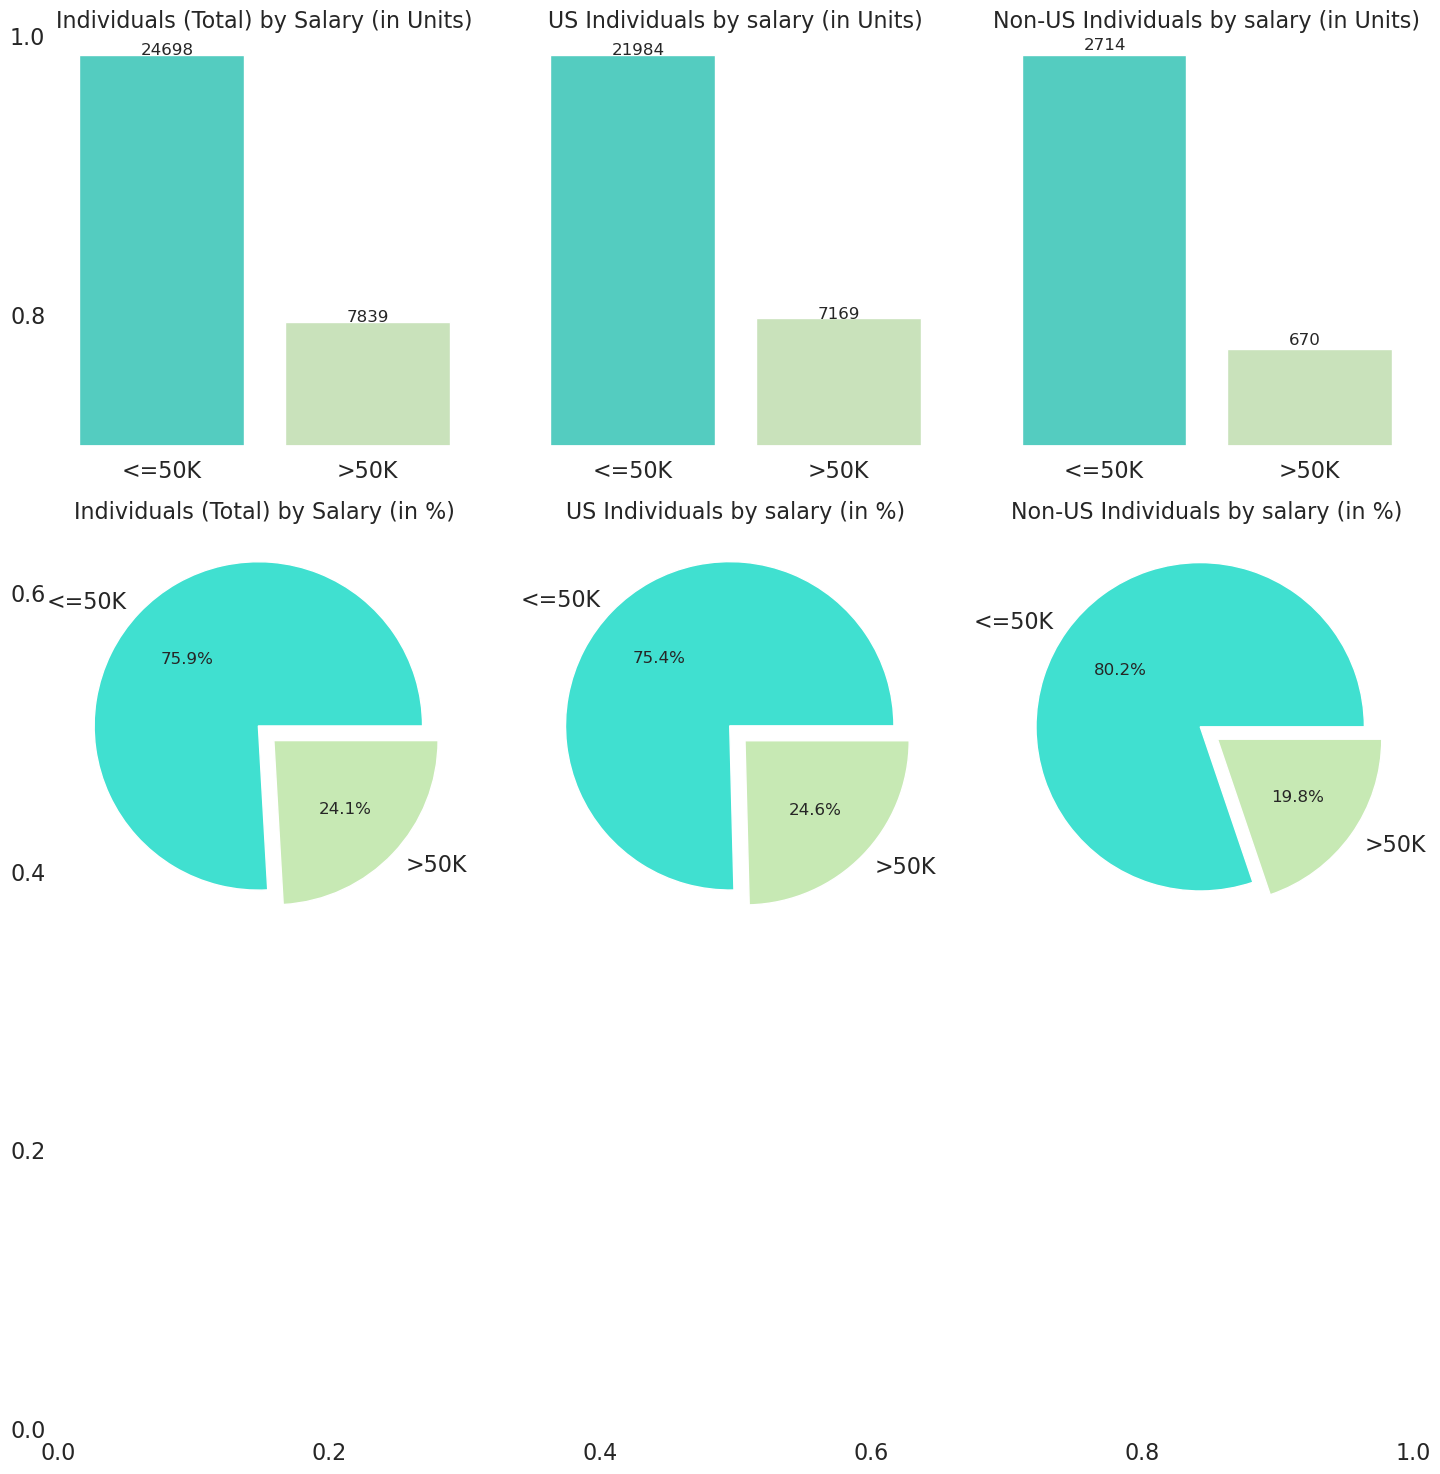

In [51]:
## Now, we will start our EDA (Exploratory Data Analysis)

## Let's take a deeper look into SALARY (the target variable in our dataset)

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':16,'ytick.labelsize':16, 'figure.autolayout':True})
my_pal = ('#40E0D0','#c7e9b4', '#EEE8AA', '#D2B48C', '#FAFAD2','#FAEBD7', '#D8BFD8','#F4A460','#F08080')
my_xpl = [0.05, 0.08]

plt.subplots(figsize=(15,15))

## Total Individuals by Salary (in Units)
plt.subplot(3,3,1)
plt.title('Individuals (Total) by Salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=df, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## US Individuals by Salary (in Units)
plt.subplot(3,3,2)
plt.title('US Individuals by salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=USA, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))
plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## Non-US Individuals by Salary (in Units)
plt.subplot(3,3,3)
plt.title('Non-US Individuals by salary (in Units)', fontsize=16)
ax = sns.countplot(x="salary", data=NonUSA, palette=my_pal, order=df['salary'].value_counts().index)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))

plt.xlabel(None), plt.ylabel(None), plt.yticks([])

## Total Individuals by Salary (in %)
plt.subplot(3,3,4)
plt.title('Individuals (Total) by Salary (in %)', fontsize=16)
df['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## US Individuals by Salary (in %)
plt.subplot(3,3,5)
plt.title('US Individuals by salary (in %)', fontsize=16)
USA['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Non US Individuals by Salary (in %)
plt.subplot(3,3,6)
plt.title('Non-US Individuals by salary (in %)', fontsize=16)
NonUSA['salary'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

plt.show()

Some Observations

It appears that the dataset is somewhat imbalanced as over 3/4th of the records belong to <=50k salary segment. The >50k salary segment is just around 24%.

Furthermore, it is observed that USA has a higher number of over 50k salaried individuals at around 24%, which is at par with the overall share.

In NonUSA countries segment, share of below 50k salary salaried indivisuals is higher than overall (USA + NonUSA) share, at around 80%.

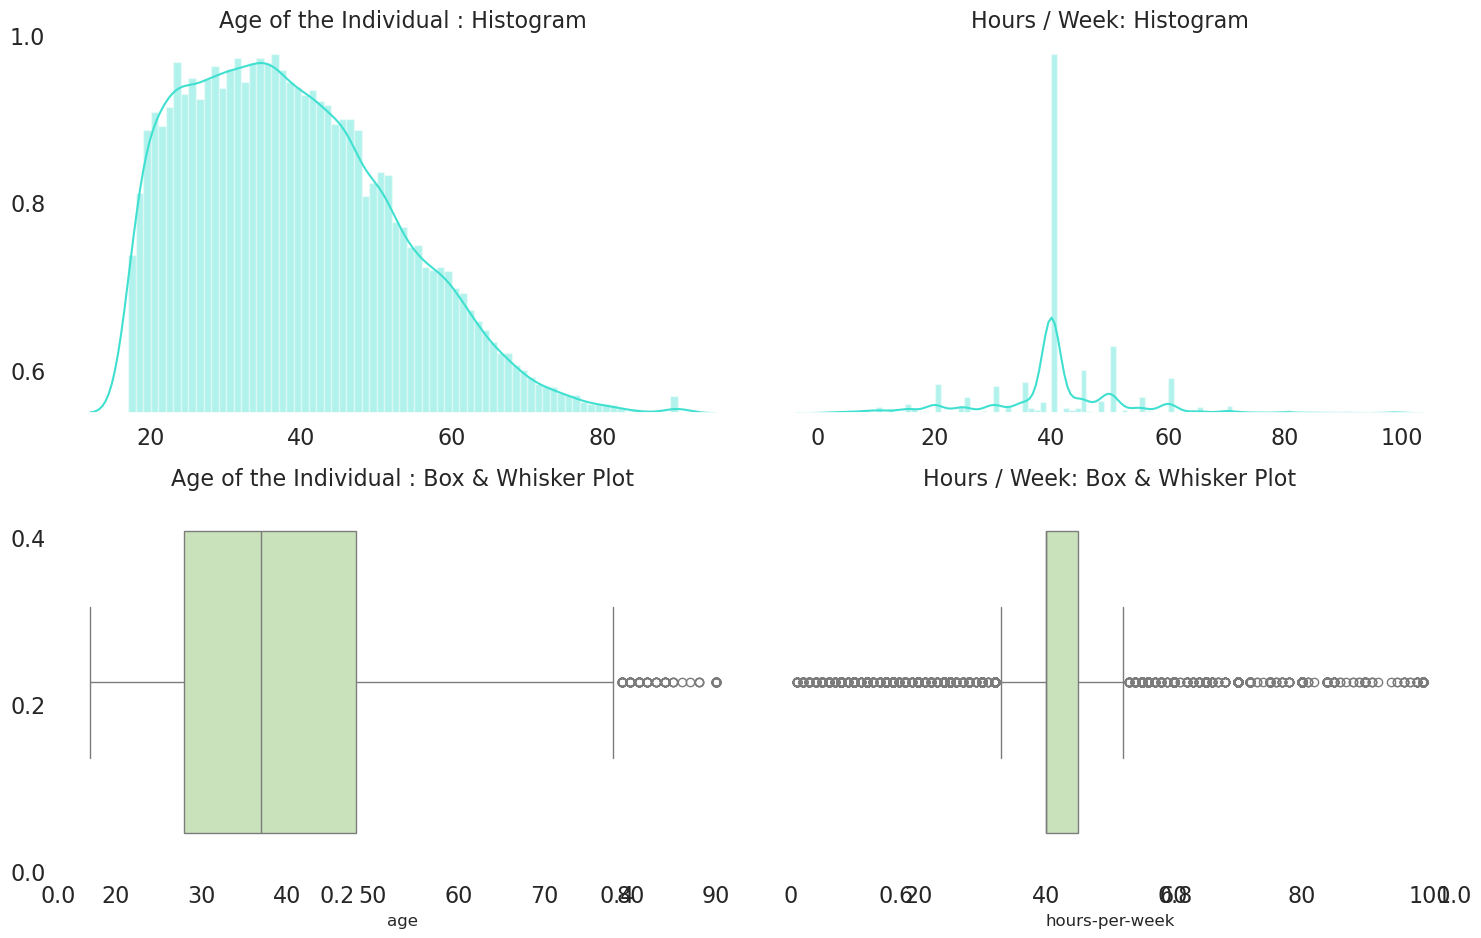

In [211]:
## Now Let's do some analysis of numerical variables in our dataset
## Age and Hours worked / week are the two numerical variables we have here

## We analyse these variables with histograms and box & whisker plots to understand distribution and identify outliers

plt.subplots(figsize=(15,10))

plt.subplot(2,2,1)
plt.title('Age of the Individual : Histogram',fontsize=16)
sns.distplot(df.age, color='#40E0D0', bins=73)
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.subplot(2,2,2)
plt.title('Hours / Week: Histogram', fontsize=16)
sns.distplot(df['hours-per-week'], color='#40E0D0', bins=98)
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.subplot(2,2,3)
plt.title('Age of the Individual : Box & Whisker Plot', fontsize=16)
sns.boxplot(df['age'], orient='h',color="#c7e9b4")

plt.subplot(2,2,4)
plt.title('Hours / Week: Box & Whisker Plot', fontsize=16)
sns.boxplot(df['hours-per-week'], orient='h', color="#c7e9b4")

plt.show()

Some Observations

Both Age and Hours / week features have significant number of outliers.
In age feature, you can see individuals aged 70 years and above
Similarly, in hours / week feature, you can see individuals working for 70 hours or more.
even for self employed people, working for 70 hours / week is extremely difficult.

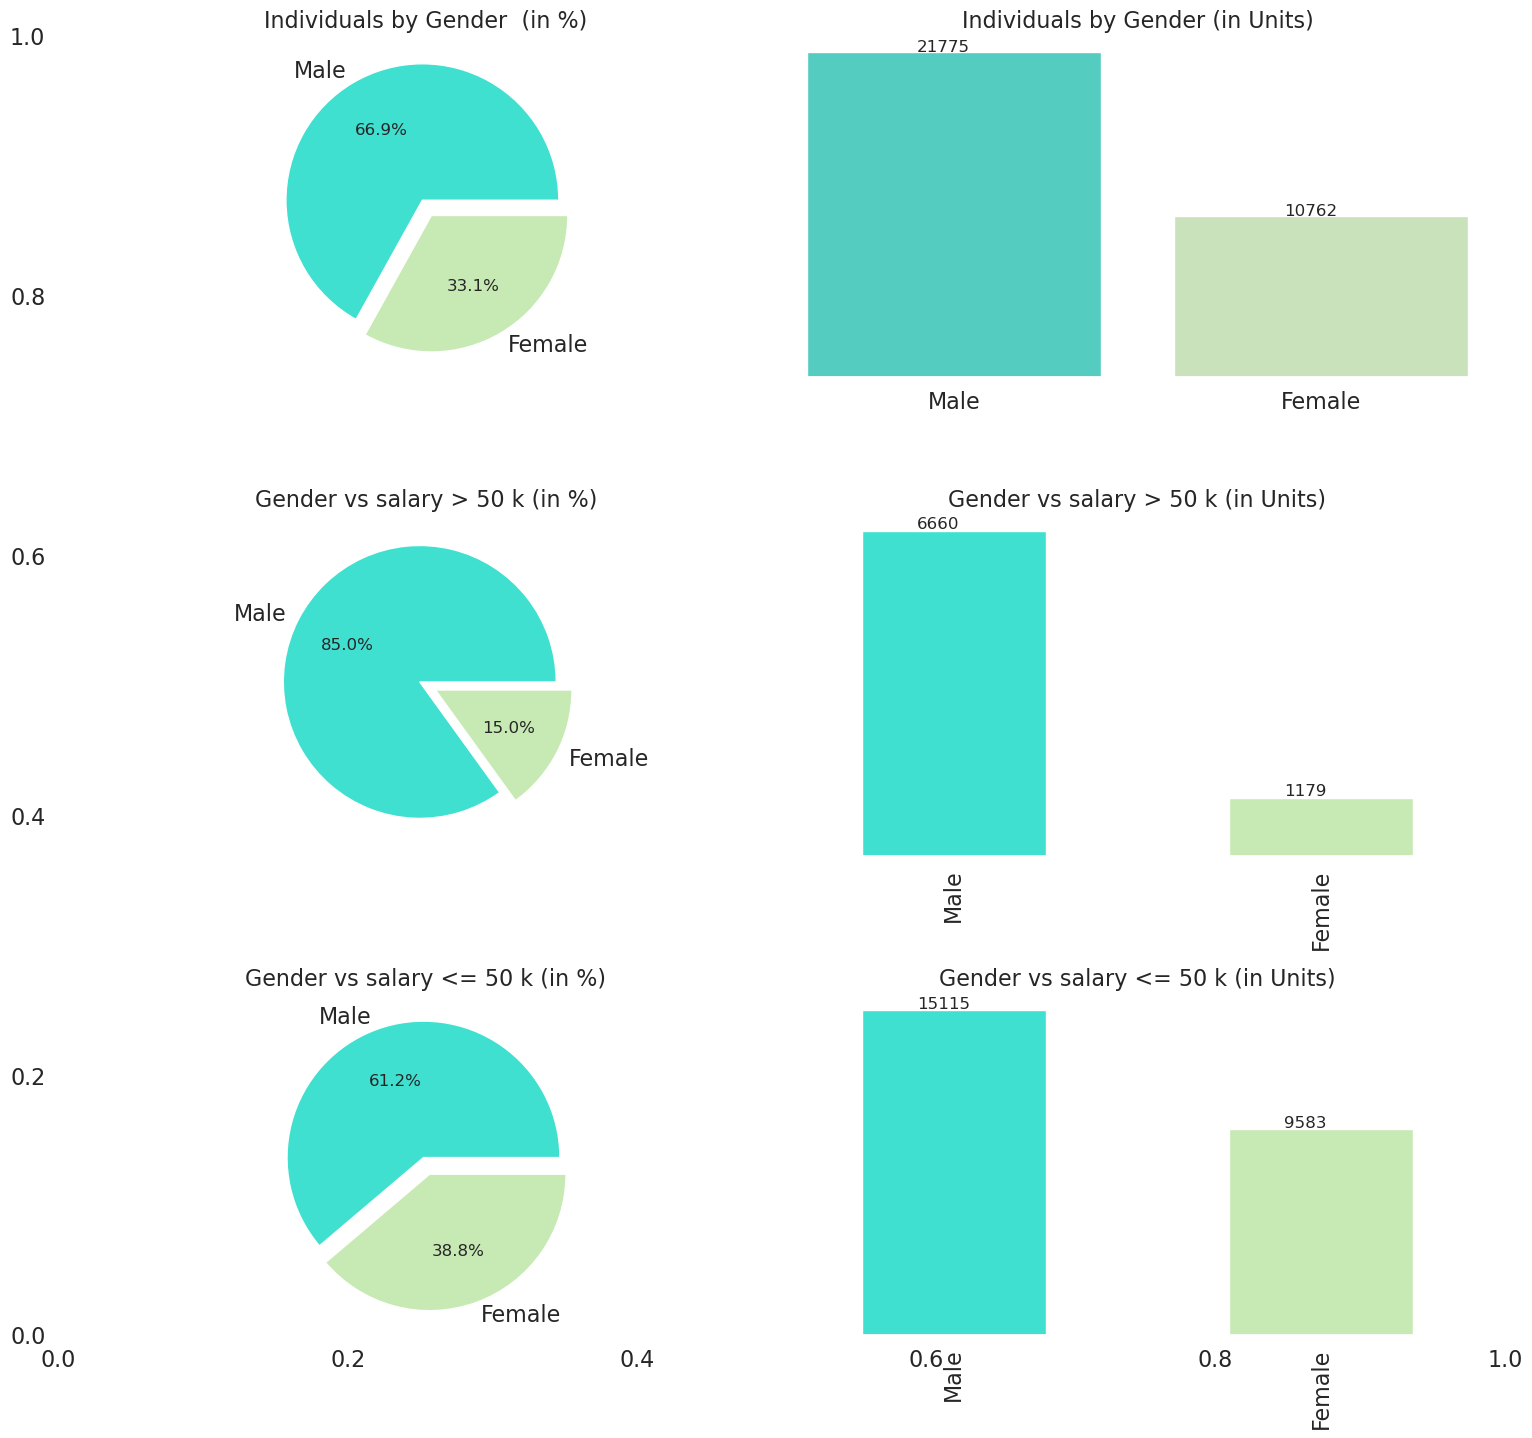

In [212]:
## Now let's analyse the categorical variables in the dataset

## Workclass, education, marital-status, occupation, relationship, race, sex, and native-country are the main categorical variables we have in our dataset

## We'll analyse a few of them, starting from Gender (sex) variable

plt.subplots(figsize=(15,15))
my_xpl = [0.05, 0.08]

## Gender (in %)
plt.subplot(3,2,1)
plt.title('Individuals by Gender  (in %)', fontsize=16)
df['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Gender (in Units)
plt.subplot(3,2,2)
plt.title('Individuals by Gender (in Units)',fontsize=16)
ax = sns.countplot(x="sex", data=df, palette=my_pal, order=df['sex'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Gender > 50 k (in %)
plt.subplot(3,2,3)
plt.title('Gender vs salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Gender > 50 k (in Units)
plt.subplot(3,2,4)
plt.title('Gender vs salary > 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='>50K']['sex'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Gender < = 50 k (in %)
plt.subplot(3,2,5)
plt.title('Gender vs salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['sex'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## Gender <= 50 k (in Units)
plt.subplot(3,2,6)
plt.title('Gender vs salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['sex'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()

Some Observations

Seems some serious discrepancy in gender vs salary, as female individuals account for just 15% of the >50k salary segment.
Whereas, females account for nearly 40% of <=50k salary segment.
It seems in the USA, gender disparity is higher since the country accounts for nearly 90% of the total records.

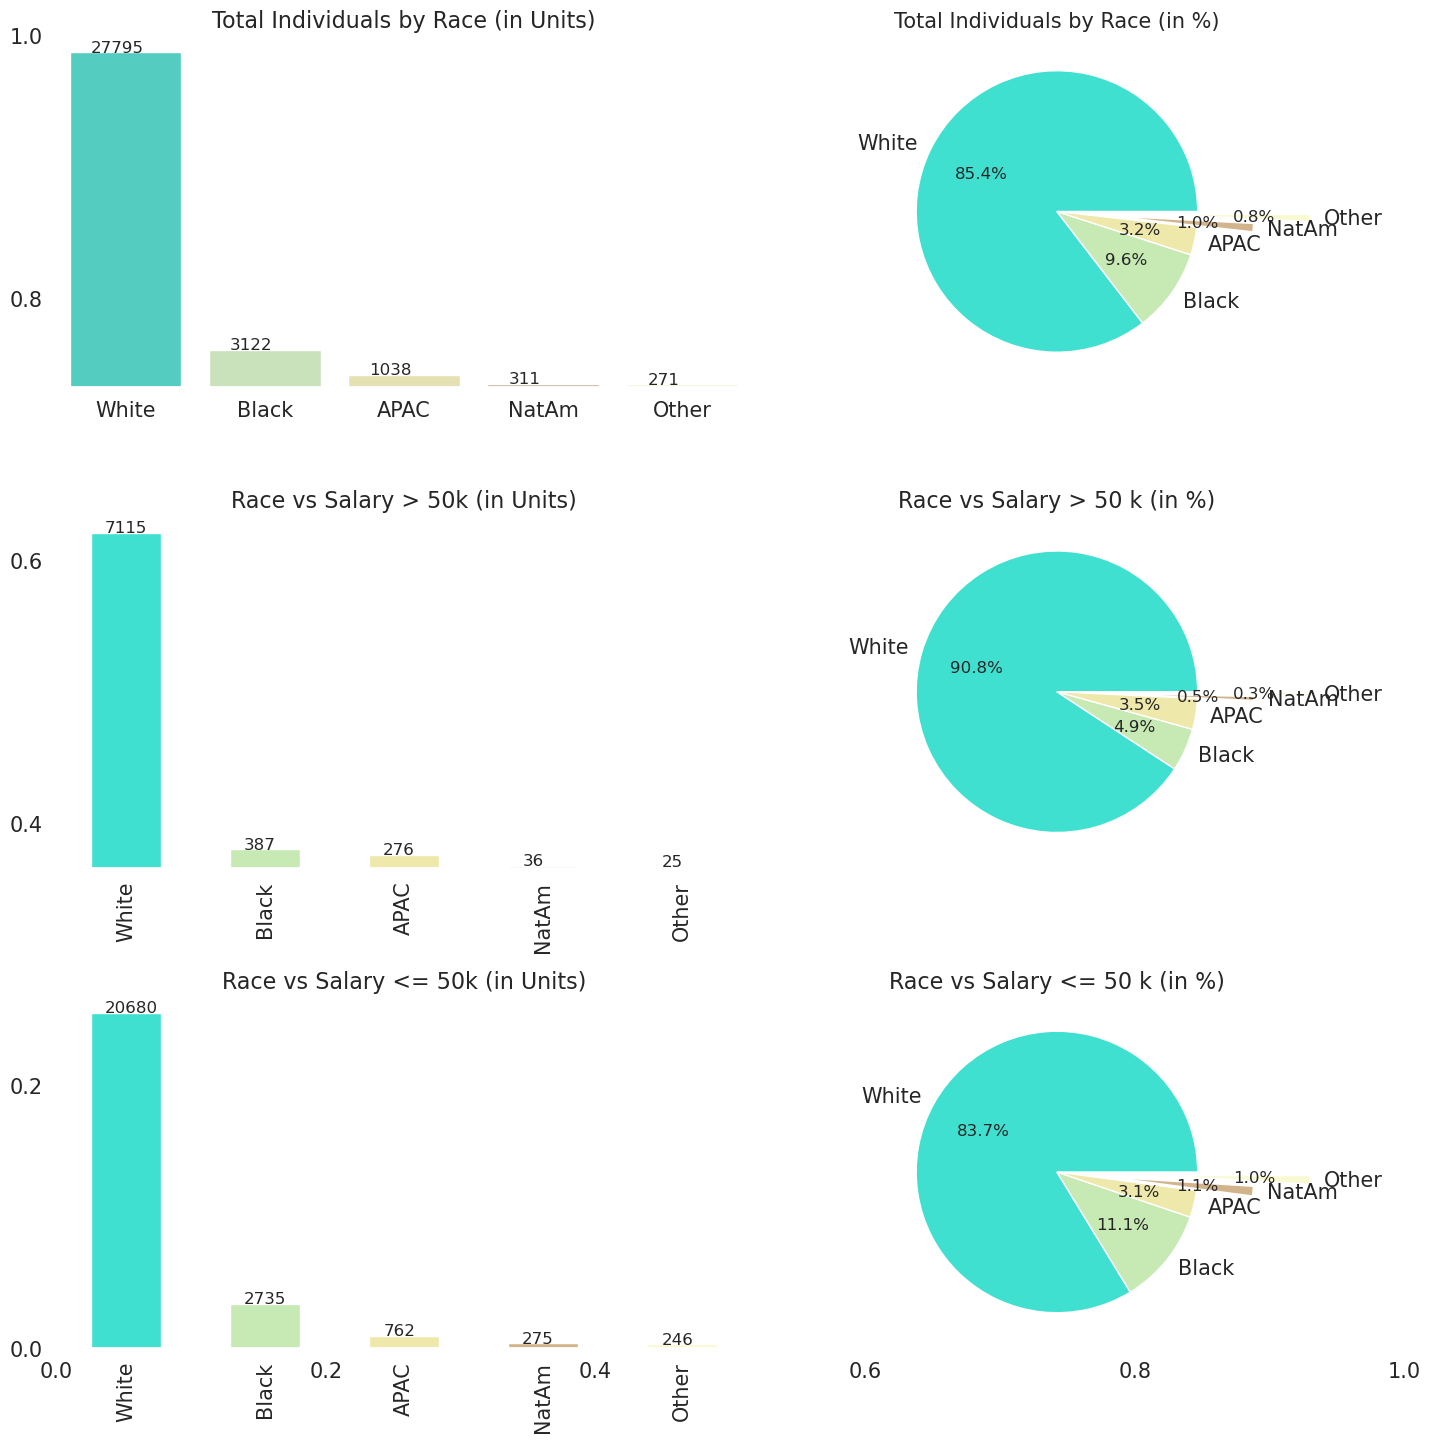

In [213]:
## Analysis of Race feature

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':15,'ytick.labelsize':15, 'figure.autolayout':True})

plt.subplots(figsize=(15,15))
my_xpl = [0, 0, 0, 0.4, 0.8]

## race total (in Units)
plt.subplot(3,2,1)
plt.title('Total Individuals by Race (in Units)', fontdict={'fontsize':16})
ax = sns.countplot(x="race", data=df, palette=my_pal, order=df['race'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+25))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary (in Units)
plt.subplot(3,2,2)
plt.title('Total Individuals by Race (in %)', fontdict={'fontsize':15})
df['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl, autopct='%1.1f%%')
 
## race by salary > 50 k (in %)
plt.subplot(3,2,3)
plt.title('Race vs Salary > 50k (in Units)', fontdict={'fontsize':16})
ax = df[df['salary']=='>50K']['race'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+8))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary  > 50 k (in %)
plt.subplot(3,2,4)
plt.title('Race vs Salary > 50 k (in %)', fontdict={'fontsize':16})
df[df['salary']=='>50K']['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl,  autopct='%1.1f%%')

## race by salary < = 50 k (in Units)
plt.subplot(3,2,5)
plt.title('Race vs Salary <= 50k (in Units)', fontdict={'fontsize':16})
ax = df[df['salary']=='<=50K']['race'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+8))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## race by salary < = 50 k (in %)
plt.subplot(3,2,6)
plt.title('Race vs Salary <= 50 k (in %)', fontdict={'fontsize':16})
df[df['salary']=='<=50K']['race'].value_counts().plot(kind='pie', colors=my_pal, legend=None, ylabel='', explode=my_xpl, autopct='%1.1f%%')

plt.show()

Key Observations

By Race, white people lead the table with over 85% share in total number of salaried individuals.
Furthermore, white people have above 90% share in over 50k salary category.

In [52]:
## Analysis of WORKCLASS feature
"""
plt.subplots(figsize=(15,12))
my_xpl = [0.15, 0.0, 0.0, 0.0]

## Workclass (in %)

plt.subplot(2,3,1)
plt.title('Workclass total (in %)', fontsize=16)
df['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass > 50 k (in %)

plt.subplot(2,3,2)
plt.title('Workclass vs salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass < = 50 k (in %)

plt.subplot(2,3,3)
plt.title('Workclass vs salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['workclass'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')


## Workclass (in Units)

plt.subplot(2,3,4)
plt.title('Workclass total (in Units)',fontsize=16)
ax = sns.countplot(x="workclass", data=df, palette=my_pal, order=df['workclass'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Workclass > 50 k (in Units)

plt.subplot(2,3,5)
plt.title('Workclass vs salary > 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='>50K']['workclass'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## Workclass <= 50 k (in Units)

plt.subplot(2,3,6)
plt.title('Workclass vs salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['workclass'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.06, p.get_height()+40))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()
"""

'\nplt.subplots(figsize=(15,12))\nmy_xpl = [0.15, 0.0, 0.0, 0.0]\n\n## Workclass (in %)\n\nplt.subplot(2,3,1)\nplt.title(\'Workclass total (in %)\', fontsize=16)\ndf[\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n## Workclass > 50 k (in %)\n\nplt.subplot(2,3,2)\nplt.title(\'Workclass vs salary > 50 k (in %)\', fontsize=16)\ndf[df[\'salary\']==\'>50K\'][\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n## Workclass < = 50 k (in %)\n\nplt.subplot(2,3,3)\nplt.title(\'Workclass vs salary <= 50 k (in %)\', fontsize=16)\ndf[df[\'salary\']==\'<=50K\'][\'workclass\'].value_counts().plot(kind=\'pie\', colors=my_pal, legend=None, explode=my_xpl, ylabel=\'\', autopct=\'%1.1f%%\')\n\n\n## Workclass (in Units)\n\nplt.subplot(2,3,4)\nplt.title(\'Workclass total (in Units)\',fontsize=16)\nax = sns.countplot(x="workclass", data=df, palette=m

Some Observations

If you observe the salary >50K pie chart (the middle one), you can understand that the share of self-employed and Govenment job holders with >50K salary is relatively higher than the respective share in total chart (first one).
And by reading the <=50K pie chart, it can be understood that the share of private employees is higher than the overall share.

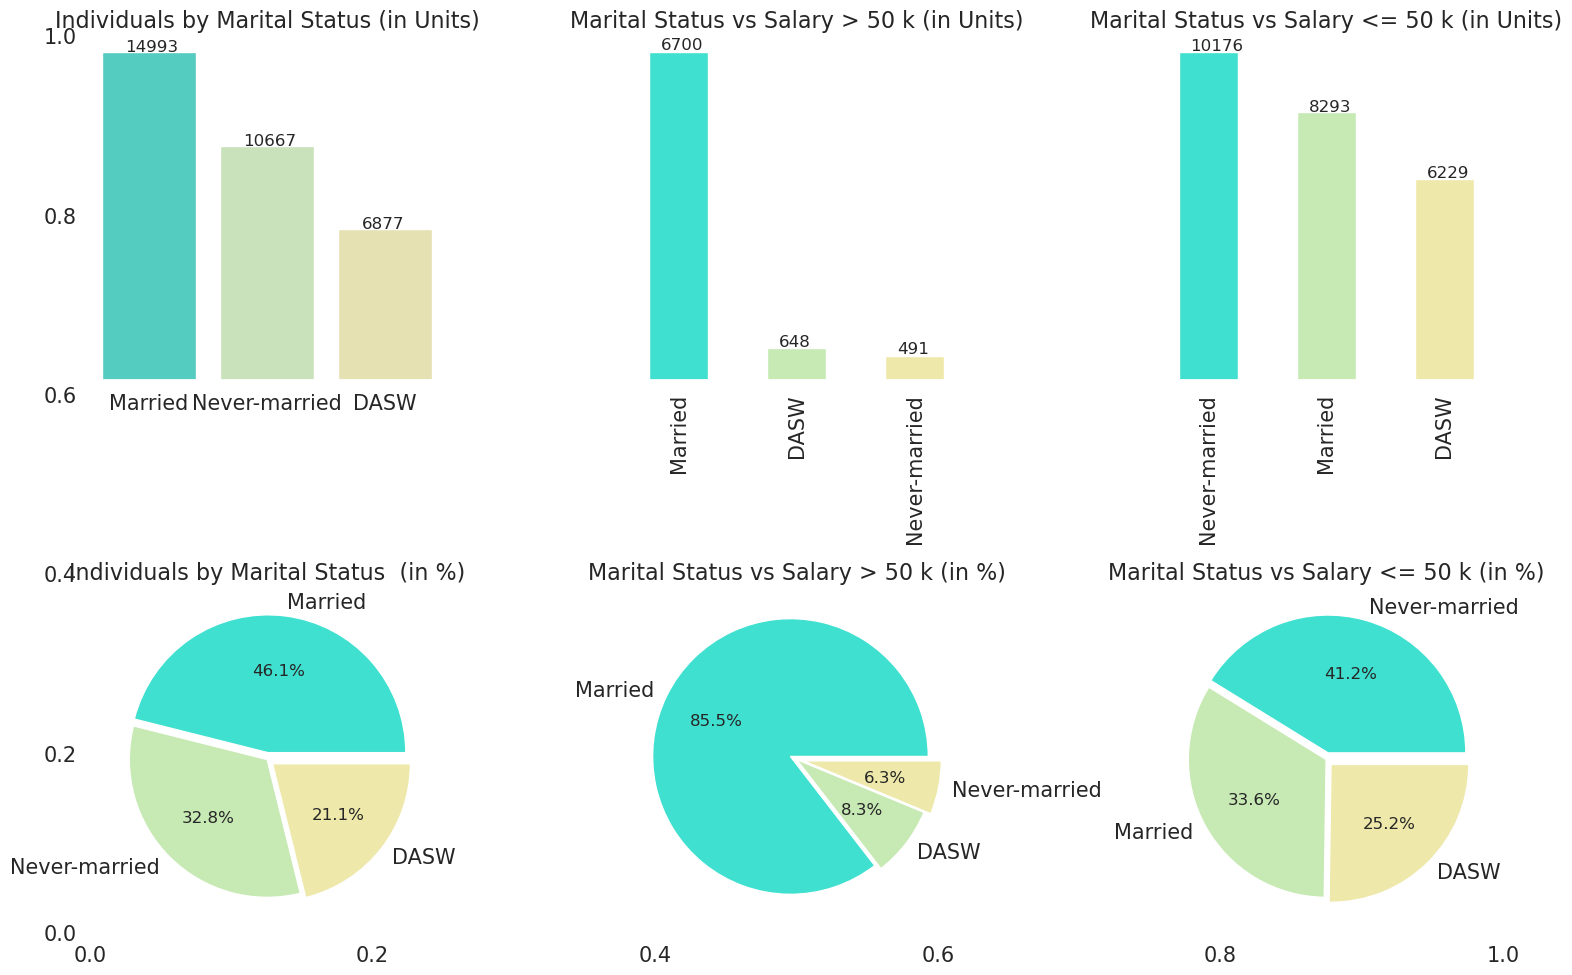

In [216]:
## Analysis of marital-status variable 

plt.subplots(figsize=(16,10))
my_xpl = [0.05, 0, 0.05]

## marital status (in Units)
plt.subplot(2,3,1)
plt.title('Individuals by Marital Status (in Units)', fontsize=16)
ax = sns.countplot(x="marital-status", data=df, palette=my_pal, order=df['marital-status'].value_counts().index)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## marital status > 50 k (in Units)
plt.subplot(2,3,2)
plt.title('Marital Status vs Salary > 50 k (in Units)',fontsize=16)
ax = df[df['salary']=='>50K']['marital-status'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)
    
## marital status <= 50 k (in Units)
plt.subplot(2,3,3)
plt.title('Marital Status vs Salary <= 50 k (in Units)', fontsize=16)
ax = df[df['salary']=='<=50K']['marital-status'].value_counts().plot(kind='bar', legend=None, color=my_pal)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

## marital status (in %)
plt.subplot(2,3,4)
plt.title('Individuals by Marital Status  (in %)', fontsize=16)
df['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## marital status > 50 k (in %)
plt.subplot(2,3,5)
plt.title('Marital Status vs Salary > 50 k (in %)', fontsize=16)
df[df['salary']=='>50K']['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

## Workclass < = 50 k (in %)
plt.subplot(2,3,6)
plt.title('Marital Status vs Salary <= 50 k (in %)', fontsize=16)
df[df['salary']=='<=50K']['marital-status'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='', autopct='%1.1f%%')

plt.show()

Some Observations

From the above plots, it is understood that Married people have higher salary, and comprise around 85% of total above 50K salaried individuals.

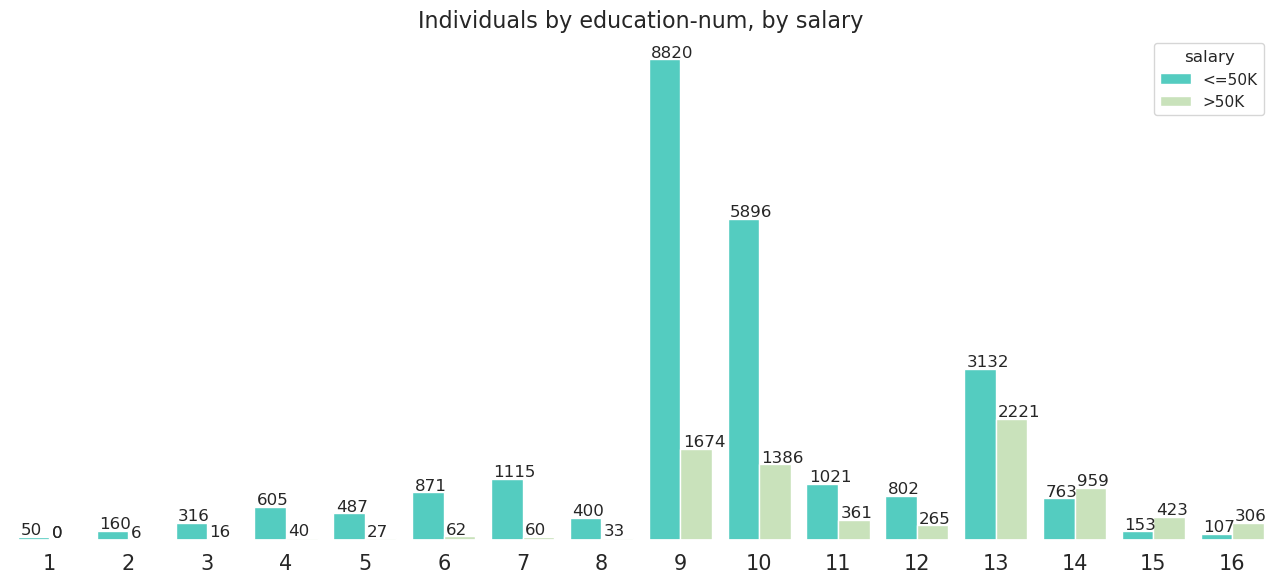

In [217]:
## Before proceeding to modeling, let's have a look at education-num feature

plt.figure(figsize=(13,6))

plt.title('Individuals by education-num, by salary', fontsize=16)
ax = sns.countplot(x='education-num', hue='salary', palette=my_pal, data=df)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.03, p.get_height()+50))

plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()

Some Observations

The education number 9 (i.e., high School graduate) is largest of the lot, by far.
Above 50K salary is relatively much higher than <=50K for individuals with education number 14 (Masters), education number 15 (Professional school), and education number 16 (Doctorate).
And it is vice versa for education number 1 through to 8.
All in all, number of individuals is higher from education number 9 to education number 13.

In [47]:
## Okay, we will stop our eda there, and start with Model Building & Machine Learning

## Grouping the features into numerical & categorical 

num_df = df[['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']] 
cat_df = df[['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country', 'salary']]

In [18]:
for col in cat_df.columns:
    print(f"col: {col}, n_unique: {cat_df[col].nunique()}")

col: workclass, n_unique: 5
col: education, n_unique: 16
col: education-num, n_unique: 16
col: marital-status, n_unique: 3
col: occupation, n_unique: 15
col: relationship, n_unique: 6
col: race, n_unique: 5
col: sex, n_unique: 2
col: native-country, n_unique: 42
col: salary, n_unique: 2


In [20]:
print(cat_df[['education', 'education-num']].head())

   education  education-num
0  Bachelors             13
1  Bachelors             13
2    HS-grad              9
3       11th              7
4  Bachelors             13


In [99]:
data_encoded = df.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in cat_df.columns.to_list():
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])

    categorical_names[feature] = le.classes_
    encoders[feature] = le

"""
for k, v in categorical_names.items():
    print(f"k: {k}, v: {v}")

for k, v in encoders.items():
    print(f"k: {k}, v: {v}")
"""

'\nfor k, v in categorical_names.items():\n    print(f"k: {k}, v: {v}")\n\nfor k, v in encoders.items():\n    print(f"k: {k}, v: {v}")\n'

In [100]:
print(df.shape)
print(data_encoded.shape)

(32537, 15)
(32537, 15)


In [101]:
def decode_dataset(data, encoders, categorical_features):
    df = data.copy()

    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [31]:
numerical_features = num_df.columns.to_list()
categorical_features = cat_df.columns.to_list()

result = decode_dataset(data_encoded, encoders, categorical_features)

print("## RESULT : ORIGINAL ##")
print(result.head())

print("## DATA ENCODED : READY FOR THE MODEL ##")
print(data_encoded.head())

## RESULT : ORIGINAL ##
   age workclass  fnlwgt  education  education-num marital-status  \
0   39     Govt.   77516  Bachelors             13  Never-married   
1   50  self_emp   83311  Bachelors             13        Married   
2   38   Private  215646    HS-grad              9           DASW   
3   53   Private  234721       11th              7        Married   
4   28   Private  338409  Bachelors             13        Married   

      occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Adminstration  Not-in-family  White    Male          2174             0   
1      Executive        Husband  White    Male             0             0   
2       Handlers  Not-in-family  White    Male             0             0   
3       Handlers        Husband  Black    Male             0             0   
4   Profesionals           Wife  Black  Female             0             0   

   hours-per-week native-country salary  
0              40            USA  <=50K  
1       

In [102]:
## Now we check the corrleation of features with the target variable (salary)
main_df = data_encoded.copy()
corr_matrix = main_df.corr()
corr_matrix['salary'].sort_values(ascending=False)

salary            1.00
education-num     0.34
age               0.23
hours-per-week    0.23
capital-gain      0.22
sex               0.22
capital-loss      0.15
workclass         0.09
education         0.08
race              0.07
native-country    0.02
fnlwgt           -0.01
occupation       -0.04
marital-status   -0.11
relationship     -0.25
Name: salary, dtype: float64

In [103]:
## Segregating the Dependent Variable in Y-axis and Independent Variables in X-axis
## And removing the features that are considered insignificant

X = main_df.drop(columns=["salary", "fnlwgt"])
# other variables to potentially drop: "education", "race", "workclass", "native-country", "occupation", "marital-status"
y = main_df["salary"]

In [104]:
for col in X.columns:
    print(col)

age
workclass
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country


In [107]:
print(main_df.head())

   age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          1   77516          9             12               2   
1   50          4   83311          9             12               1   
2   38          2  215646         11              8               0   
3   53          2  234721          1              6               1   
4   28          2  338409          9             12               1   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1          2174             0   
1           3             0     4    1             0             0   
2           5             1     4    1             0             0   
3           5             0     1    1             0             0   
4           8             5     1    0             0             0   

   hours-per-week  native-country  salary  
0              40              39       0  
1              13              39       0  
2              40   

### 2. Prepare the dataset

Now the data is preprocessed, we can 
- create a AIF360 dataset,
- split the dataset into train, validate and test datasets,
- describe some characteristics of the dataset instances.

In [151]:
# Some imports are needed.

import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.explainers import MetricTextExplainer


default_mappings = {
    'label_maps': [{1.0: '>=50K', 0.0: '<50K'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}

# label_names refers to the target name(s).
# protected attribute names refers to the names of 
# the sensitive variable, i.e. the protected variable.

label_names = ['salary']
protected_attribute_names = ['sex']

# Create a AIF360 dataset instance

salary_ds = BinaryLabelDataset(
    df=main_df, 
    label_names=['salary'], 
    protected_attribute_names=['sex'],
    favorable_label=1.0, 
    unfavorable_label=0.0,
    unprivileged_protected_attributes=[[0]],  # For 'Female' if 'sex' is binary-coded
    privileged_protected_attributes=[[1]],    # For 'Male' if 'sex' is binary-coded
    metadata=default_mappings
)


In [122]:
# Split the dataset into train, validate and test datasets.

(salary_orig_train,
salary_orig_val,
salary_orig_test) = salary_ds.split([0.5, 0.8], shuffle=True, seed=0)

In [123]:
# describe some characteristics of the dataset instances
# This function will be used throughout the notebook to print out some labels, names, etc.

def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [124]:
describe(salary_orig_train, salary_orig_val, salary_orig_test)

#### Training Dataset shape

(16268, 14)


#### Validation Dataset shape

(9761, 14)


#### Test Dataset shape

(6508, 14)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[[1]] [[0]]


#### Dataset feature names

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


### 3. Metrics for the original data

Create a metric instance

In [129]:
metric_salary_orig_train = BinaryLabelDatasetMetric(salary_orig_train,
                                                    unprivileged_groups = [{'sex':0}],
                                                    privileged_groups = [{'sex':1}])

Use this metric instance to calculate the disparate impact on the training data:

In [130]:
print(metric_salary_orig_train.disparate_impact())

0.3621944602924232


If you want some explanation about what the "disparate impact" measures, what it means, create an explainer instance first:

In [189]:
# from aif360.explainers import MetricTextExplainer

explainer_salary_orig_train = MetricTextExplainer(metric_salary_orig_train)

print(explainer_salary_orig_train.disparate_impact())

DI = metric_salary_orig_train.disparate_impact()

print(f"disparate impact on dataset after reweighing: {DI}")
print(f"1-min(DI, 1/DI) on dataset after reweighing: {1-min(DI, 1/DI)}")


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.3621944602924232
disparate impact on dataset after reweighing: 0.3621944602924232
1-min(DI, 1/DI) on dataset after reweighing: 0.6378055397075768


### 4. Learning a Random Forest (RF) classifier on the original data 

#### 4.1. Training RF model on original data

In [137]:
print(salary_orig_train.instance_weights)

[1. 1. 1. ... 1. 1. 1.]


In [143]:
dataset = salary_orig_train
model = make_pipeline(RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_salary_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.2 Validating RF model on original data

"test" is a helper function to evaluate the trained model, w.r.t.
- performance,
- bias,

on different thresholds.

In the test function, an instance of "ClassificationMetric" is used. When we want to calculate bias metrics on a model's outcome, the "ClassificationMetric" is used. 

ref. https://aif360.res.ibm.com/resources#guidance

In [157]:
from collections import defaultdict
from aif360.metrics import ClassificationMetric

def test(dataset, model, thresh_arr, unprivileged_groups=[], privileged_groups=[]):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

Plot metrics with twin x-axes.

In [162]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 1.0)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.9)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Describe the calculates metrics.

In [167]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [163]:
thresh_arr = np.linspace(0.01, 0.5, 50)

val_metrics = test(dataset=salary_orig_val,
                   model=rf_salary_orig,
                   thresh_arr=thresh_arr,
                   unprivileged_groups = [{'sex':0}],
                   privileged_groups = [{'sex':1}])

rf_salary_orig_best_ind = np.argmax(val_metrics['bal_acc'])

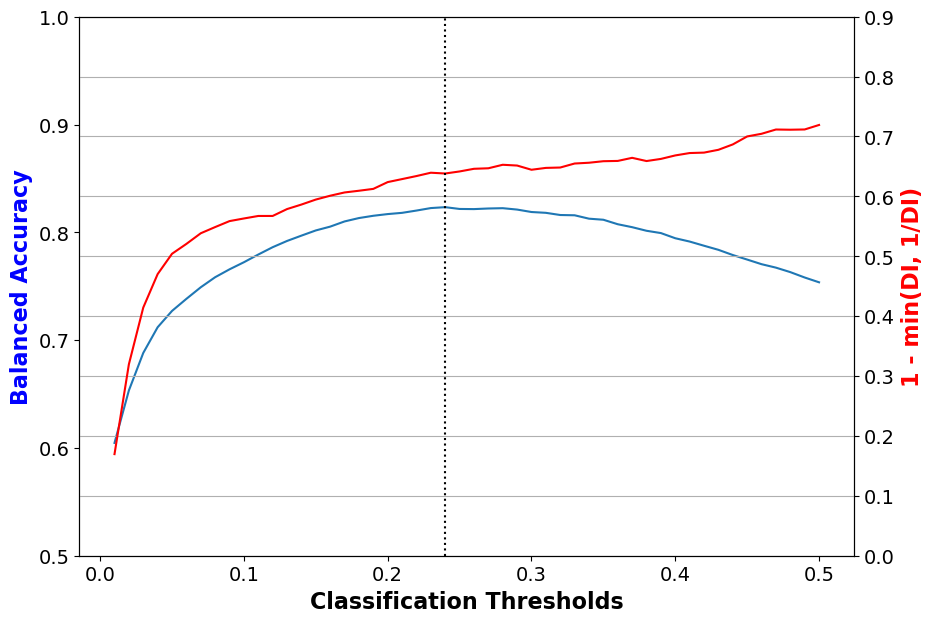

In [164]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

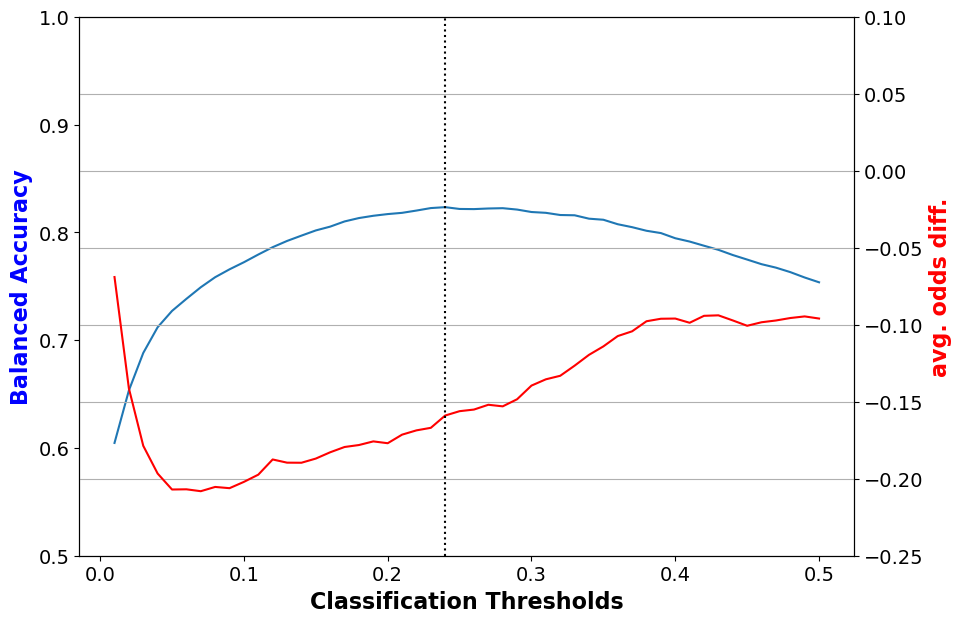

In [165]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [168]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.8233
Corresponding 1-min(DI, 1/DI) value: 0.6382
Corresponding average odds difference value: -0.1590
Corresponding statistical parity difference value: -0.3092
Corresponding equal opportunity difference value: -0.1031
Corresponding Theil index value: 0.0767


#### 4.3 Testing RF model on original data

In [176]:
rf_orig_metrics = test(dataset=salary_orig_test,
                       model=rf_salary_orig,
                       thresh_arr=[thresh_arr[rf_salary_orig_best_ind]],
                       unprivileged_groups = [{'sex':0}],
                       privileged_groups = [{'sex':1}])

In [177]:
print(rf_salary_orig_best_ind)

23


In [178]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_salary_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.8237
Corresponding 1-min(DI, 1/DI) value: 0.6995
Corresponding average odds difference value: -0.1853
Corresponding statistical parity difference value: -0.3468
Corresponding equal opportunity difference value: -0.1400
Corresponding Theil index value: 0.0765


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a random forest classifier trained with the original training data, at the best classification rate, this is quite high (here: 0.6995). This implies unfairness.

Similarly, the average odd difference, must be close to zero for the classifier to be fair.

### 5. Bias mitigation using pre-processing technique - Reweighing

#### 5.1 Transform data

The original dataset is biased w.r.t. gender. Use the reweighing technique to remove this particular bias from the training dataset.

In [183]:
RW = Reweighing(unprivileged_groups=[{'sex':0}],
                privileged_groups=[{'sex':1}])
dataset_salary_transf_train = RW.fit_transform(salary_orig_train)

Metrics for transformed data: when examining metrics on **data**, the "BinaryLabelDatasetMetric" can be used.

In [188]:
metric_salary_transf_train = BinaryLabelDatasetMetric(
        dataset_salary_transf_train,
        unprivileged_groups=[{'sex':0}],
        privileged_groups=[{'sex':1}])

explainer_salary_orig_train = MetricTextExplainer(metric_salary_transf_train)

print(explainer_salary_orig_train.disparate_impact())

DI = metric_salary_transf_train.disparate_impact()

print(f"disparate impact on dataset after reweighing: {DI}")
print(f"1-min(DI, 1/DI) on dataset after reweighing: {1-min(DI, 1/DI)}")



Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000004
disparate impact on dataset after reweighing: 1.0000000000000004
1-min(DI, 1/DI) on dataset after reweighing: 4.440892098500626e-16


#### 5.2. Learning a Random Forest (RF) classifier on data transformed by reweighing

##### 5.2.1 Training a RF model after reweighing

In [196]:
dataset = dataset_salary_transf_train

model = make_pipeline(RandomForestClassifier(n_estimators=500, min_samples_leaf=25))

print(f"On the transformed, i.e. reweighed dataset, the instance weights are: \n {dataset.instance_weights}")

fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}

rf_salary_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

On the transformed, i.e. reweighed dataset, the instance weights are: 
 [0.78887492 1.09267953 0.78887492 ... 0.85366696 1.09267953 0.85366696]


##### 5.2.2 Validating RF model after reweighing

In [201]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=salary_orig_val,
                   model=rf_salary_transf,
                   thresh_arr=thresh_arr,
                   unprivileged_groups = [{'sex':0}],
                   privileged_groups = [{'sex':1}])
rf_salary_transf_best_ind = np.argmax(val_metrics['bal_acc'])

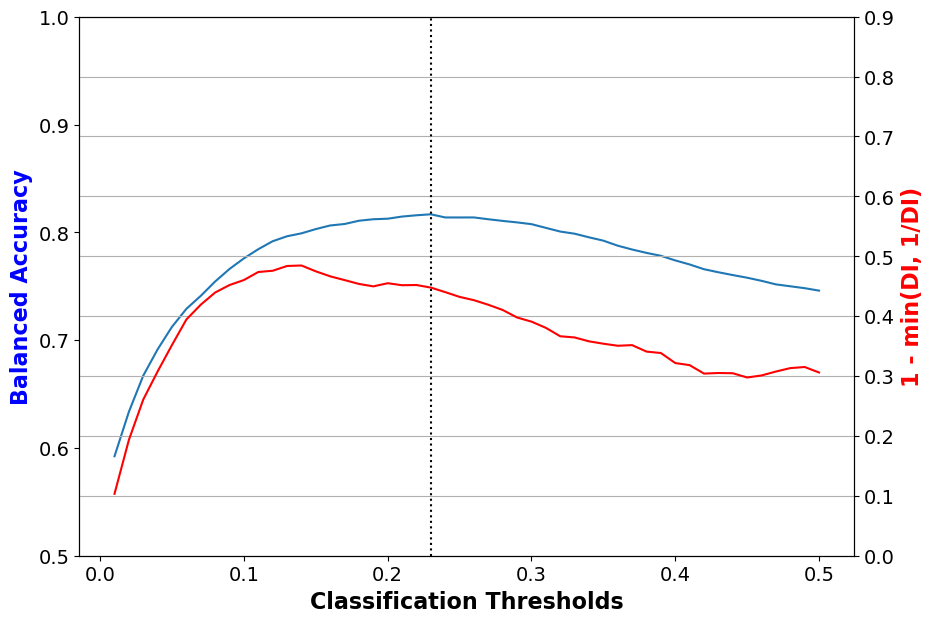

In [202]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

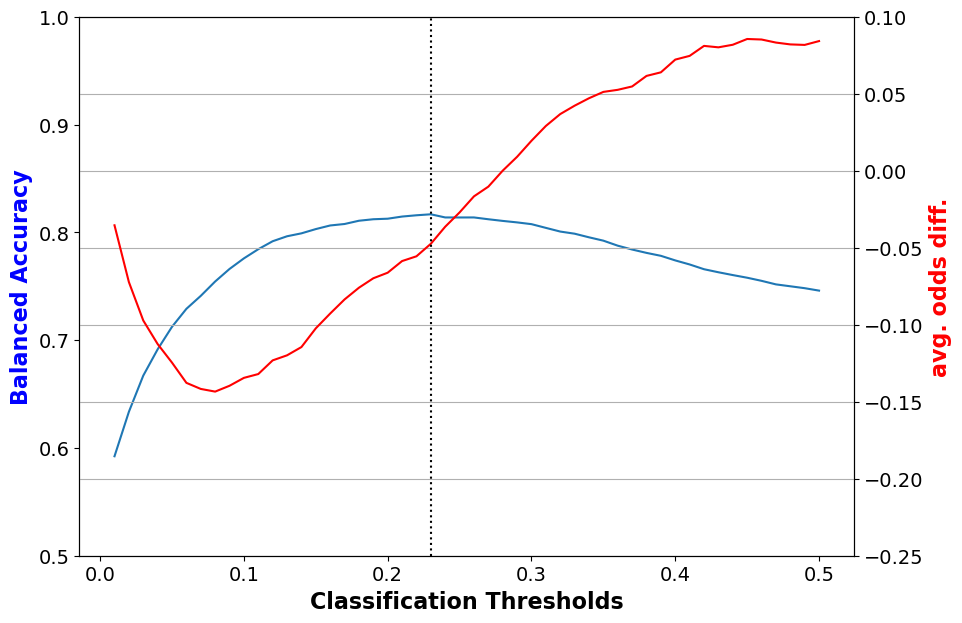

In [203]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [204]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.8167
Corresponding 1-min(DI, 1/DI) value: 0.4477
Corresponding average odds difference value: -0.0474
Corresponding statistical parity difference value: -0.2000
Corresponding equal opportunity difference value: 0.0085
Corresponding Theil index value: 0.0799


##### 5.2.3. Testing RF model after reweighing

In [206]:
rf_transf_metrics = test(dataset=salary_orig_test,
                         model=rf_salary_transf,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]],
                         unprivileged_groups = [{'sex':0}],
                         privileged_groups = [{'sex':1}])

In [207]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.8117
Corresponding 1-min(DI, 1/DI) value: 0.5137
Corresponding average odds difference value: -0.0723
Corresponding statistical parity difference value: -0.2349
Corresponding equal opportunity difference value: -0.0273
Corresponding Theil index value: 0.0821


The model learned from the transformed data is fairer than that learned from the original data. 

However, the random forest model learned from the transformed data is still relatively unfair.

### 6. Bias mitigation using in-processing technique - Prejudice Remover (PR)

#### 6.1. Learning a Prejudice Remover (PR) model on original data

Remark: the prejudice remover trains a new model, this is described in the documentation (ref. https://github.com/Trusted-AI/AIF360/blob/main/aif360/algorithms/inprocessing/prejudice_remover.py).

It is used here to demonstrate an "inprocessing" bias mitigation technique.

This is only one of the options, and one particular implementation, use as an example.

##### 6.1.1 Training a PR model

In [214]:
from aif360.algorithms.inprocessing import PrejudiceRemover

model = PrejudiceRemover(sensitive_attr="sex", eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = salary_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_salary_orig = model.fit(dataset)

##### 6.1.2 Validating a PR model

In [218]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = salary_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_salary_orig,
                   thresh_arr=thresh_arr,
                   unprivileged_groups = [{'sex':0}],
                   privileged_groups = [{'sex':1}])

pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

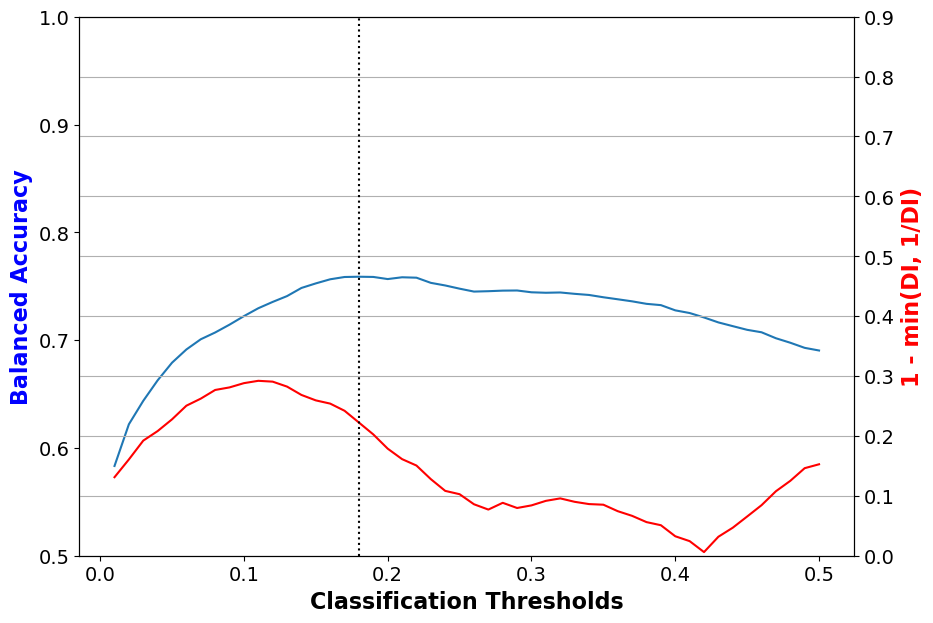

In [219]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

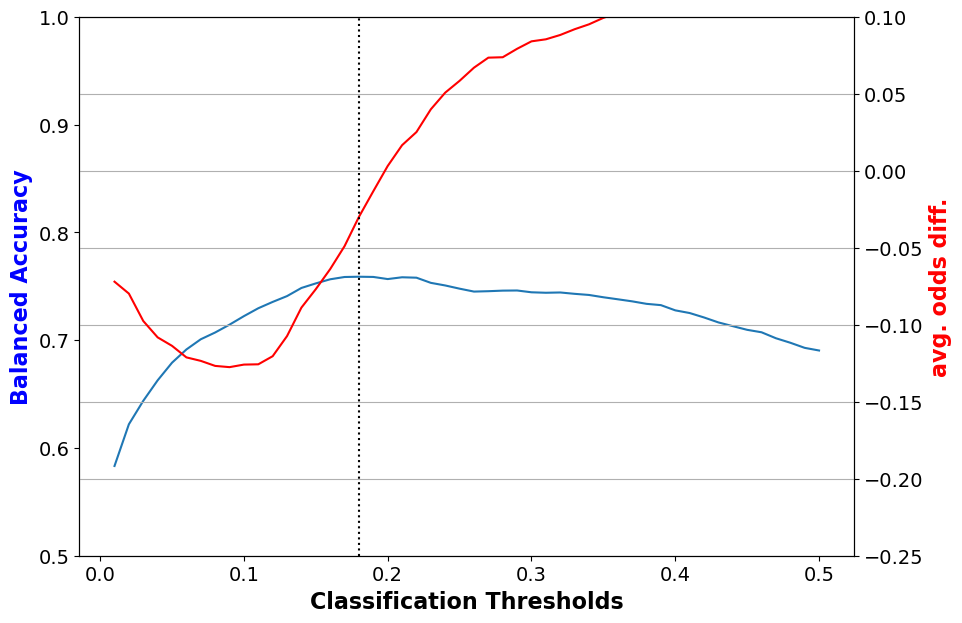

In [220]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [221]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7588
Corresponding 1-min(DI, 1/DI) value: 0.2223
Corresponding average odds difference value: -0.0300
Corresponding statistical parity difference value: -0.1047
Corresponding equal opportunity difference value: -0.0600
Corresponding Theil index value: 0.0960


##### 6.1.3. Testing a PR model

In [224]:
dataset = salary_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_salary_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]],
                       unprivileged_groups = [{'sex':0}],
                       privileged_groups = [{'sex':1}])

In [225]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7574
Corresponding 1-min(DI, 1/DI) value: 0.1804
Corresponding average odds difference value: 0.0010
Corresponding statistical parity difference value: -0.0846
Corresponding equal opportunity difference value: -0.0368
Corresponding Theil index value: 0.0955


As in the case of reweighing, prejudice remover results in a fairer model. 

However, it has come at the expense of relatively lower balanced accuracy.

### 7. Summary of model learning results

In [232]:
import pandas as pd

pd.set_option('display.multi_sparse', False)

results = [rf_orig_metrics, 
           rf_transf_metrics, pr_orig_metrics]

# print(results)
print(len(results))

debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')

print(debias)

clf = pd.Series(['Random Forest']*2 + [''],
                name='Classifier')

res = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

print(res)

3
0                     
1           Reweighing
2    Prejudice Remover
Name: Bias Mitigator, dtype: object
                                 bal_acc  avg_odds_diff  disp_imp  \
Bias Mitigator    Classifier                                        
                  Random Forest     0.82          -0.19      0.30   
Reweighing        Random Forest     0.81          -0.07      0.49   
Prejudice Remover                   0.76           0.00      0.82   

                                 stat_par_diff  eq_opp_diff  theil_ind  
Bias Mitigator    Classifier                                            
                  Random Forest          -0.35        -0.14       0.08  
Reweighing        Random Forest          -0.23        -0.03       0.08  
Prejudice Remover                        -0.08        -0.04       0.10  


In this code, we've examined bias in the salary dataset.
We've also examined bias on the outcome of the model.

We've tried to mitigate the bias, by applying a bias mitigation technique
- on the data, the technique used being reweighing,
- while training. For this we've used a particular model, the "prejudice remover".
  
Of the models trained, the reweiged random forest model gives the best balance in terms of balanced accuracy and fairness. 

Remark that the  model learnt by the prejudice remover is fairer than the original trained random forest, it has much lower accuracy. 

Remark that this is an example for learning to use some bias detection and bias mitigation techniques.

In practice, you'd pay more attention to your train_test_split, to the way you train your models, you'd try several other techniques too, depending on the use case.